# Estimating Factor Loading

Galvao et al estimated quarterly factor loading from daily data.

## Notebook setup

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.executable

'/Users/fanghema/Desktop/aaSTAT_5200/STAT_5200_final_project/env/bin/python'

For now, we load in Galvao et al's replication data. 

In [2]:
data = pd.read_csv(
    '../data/processed/data_galvao.csv',
    index_col=0,
    parse_dates=True
)

In [3]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
assets = [col for col in data.columns if col != 'RF' and col not in factors]

## Factor Loading Function

In [4]:
def calculate_factor_loading(
    input_df: pd.DataFrame,
    factors: list[str],
    assets: list[str],
) -> tuple[pd.DataFrame, pd.DataFrame]: 
    """
    Given DataFrame of (non-excess) asset returns 
    and factor returns, 
    returns panel data of factor loadings

    Args:
        input_df (pd.DataFrame): DataFrame indexed on date,
            with column names corresponding to assets
        factors (list[str]): list of factors
        assets (list[str]): list of risky assets

    Returns:
        pd.DataFrame: panel data of factor loadings
        pd.DataFrame: modified returns dataframe with excess returns
    """

    assert type(input_df.index) == pd.DatetimeIndex, "input_df has wrong index"
    for factor in factors:
        assert factor in input_df.columns, f"missing factor {factor}"
    for asset in assets:
        assert asset in input_df.columns, f"missing asset {asset}"
    assert "RF" in input_df.columns, f"Missing risk free"
    
    input_df.sort_index(inplace=True)
    N = len(assets)
    K = len(factors)
    input_df['Quarter'] = input_df.index.to_period("Q")
    T = input_df['Quarter'].nunique()

    for col in assets:
        input_df[col] = input_df[col] - input_df["RF"]
    
    cols = list(assets) + list(factors)

    realized_covariance_matrices = np.zeros((N, K, T))

    quarters = sorted(input_df['Quarter'].unique())
    for i, quarter in enumerate(quarters):
        returns = (
            input_df.loc[
                input_df['Quarter'] == quarter,
                cols
            ]
            .values
        )
        Omega_hat_t = returns.T @ returns
        realized_covariance_matrices[:, :, i] = Omega_hat_t[:N, N:N+K]
    
    beta_loading = pd.DataFrame(
        index = pd.MultiIndex.from_product([assets, factors]),
        columns = input_df['Quarter'].unique(),
    )

    for i, asset in enumerate(assets):
        for j, factor in enumerate(factors):
            omega_i_j_series = realized_covariance_matrices[i, j, :]
            Y = omega_i_j_series[1:]
            X = (
                np.column_stack([
                    np.ones(len(Y)),
                    omega_i_j_series[:-1]
                ])
            )
            b = np.linalg.lstsq(X, Y, rcond=None)[0]
            delta0, delta1 = b
            beta_loading.loc[(asset, factor)] = delta0 + delta1 * omega_i_j_series

    return beta_loading, input_df

beta_loading, _ = calculate_factor_loading(data, factors=factors, assets=assets)


In [5]:
beta_loading

1963Q3     1963Q4     1964Q1     1964Q2     1964Q3  \
Agric Mkt-RF  30.361188   29.34117  30.059214  30.543622  30.323886   
      SMB      1.816013    1.79645   1.741765   1.853506   1.473105   
      HML     -1.600764  -3.201627  -1.574742   0.111486  -3.858092   
      RMW     -1.466798   0.215607  -2.085727  -1.616463   -0.83943   
      CMA     -3.153214  -2.825331  -3.644188  -2.283014  -4.513127   
...                 ...        ...        ...        ...        ...   
Other Mkt-RF  37.969554  45.784074  34.019282  34.391633  34.792978   
      SMB     -1.998767  -2.640143   -0.85192  -0.306529  -0.633693   
      HML     -0.917399   1.711179  -1.088099  -3.044638  -1.742651   
      RMW     -1.124262  -2.770248  -2.015389  -2.132075  -3.193049   
      CMA     -5.789944  -6.603539  -5.826818  -6.053781  -5.221453   

                 1964Q4     1965Q1     1965Q2     1965Q3     1965Q4  ...  \
Agric Mkt-RF  30.703206  31.228282  37.229192  32.067519  31.861254  ...   
      SMB       2.00402   3.045183   4.653787   1.888597   5.220041  ...   
      HML     -0.235879   0.086952  -1.560099  -0.679981   0.349221  ...   
      RMW     -2.021263  -0.083306   0.020307   0.034482  -0.414664  ...   
      CMA     -2.645516  -0.616308  -3.777817  -3.716449  -2.888483  ...   
...                 ...        ...        ...        ...        ...  ...   
Other Mkt-RF  34.918142  35.850948  44.439513  35.915049  35.431179  ...   
      SMB      1.262379   0.756938   7.587363   1.695747   2.722596  ...   
      HML     -1.884642  -2.515519  -2.530227  -2.782289   -0.82352  ...   
      RMW     -2.799131  -1.728237  -1.088422   -0.85667  -2.905094  ...   
      CMA     -4.204414   -4.85491  -7.189725  -5.199381  -4.323135  ...   

                 2012Q3     2012Q4     2013Q1     2013Q2     2013Q3  \
Agric Mkt-RF  38.230127  44.228211  39.335887  48.107139  35.757627   
      SMB      2.825341    2.55903   1.395667   6.672073   0.987797   
      HML     -0.932763   -0.81881   0.285446   3.049976  -1.072834   
      RMW     -2.202299   0.605827  -3.652465  -4.020965  -3.187997   
      CMA      -4.54621  -5.343885  -2.406726  -2.818723  -1.857074   
...                 ...        ...        ...        ...        ...   
Other Mkt-RF  45.704996   49.68986  45.765309  55.216365  43.633398   
      SMB      0.412122  -0.559866   1.345408   4.362684   1.628486   
      HML      0.311998   1.521048   1.230703   2.823396  -0.727235   
      RMW     -2.588129  -2.488581  -5.192548  -5.965385  -5.007897   
      CMA     -5.914405  -4.596196  -3.697755  -4.133301  -3.866694   

                 2013Q4     2014Q1     2014Q2     2014Q3     2014Q4  
Agric Mkt-RF  38.445064  40.051037  39.497776  33.855069  45.157696  
      SMB      3.595121   4.930176   4.457616   2.713055   3.671996  
      HML     -2.233552  -3.741736   -4.58758  -3.889497  -3.510954  
      RMW     -2.908149  -2.537573  -3.156205  -1.500751  -4.065958  
      CMA     -3.305422  -3.470351  -5.198915  -3.512337  -4.358914  
...                 ...        ...        ...        ...        ...  
Other Mkt-RF  46.574096  49.724401  40.962994  42.389573  54.260984  
      SMB      1.340596     2.8245   2.506789   0.791631  -1.422422  
      HML       -2.7199  -2.724412   -3.61055  -4.402122  -3.550449  
      RMW      -4.39195  -3.473228  -3.751173  -3.608661  -4.698762  
      CMA     -5.743321  -5.302565  -5.333998  -5.560285  -5.226873  

[235 rows x 206 columns]

## Sanity Check

As a sanity check, we call our function on Galvao's original dataset, and compare the estimated beta loading against the original paper's beta loadings.

In [6]:
agric_betas = pd.read_csv("../gmo-files/omegareg1.txt",
                sep=r"\s+",
                header=None)
agric_betas.columns = factors
agric_betas

,Mkt-RF,SMB,HML,RMW,CMA
0,3.60917,0.67097,0.32962,-0.66613,-1.01100
1,0.93072,0.61959,-2.20990,2.73658,-0.40266
2,2.81622,0.47597,0.37090,-1.91793,-1.92193
3,4.08822,0.76944,3.04584,-0.96883,0.60353
4,3.51122,-0.22962,-3.25128,0.60274,-3.53412
...,...,...,...,...,...
201,24.83650,5.34350,-0.67420,-3.58130,-1.29340
202,29.05360,8.84980,-3.06670,-2.83180,-1.59940
203,27.60080,7.60870,-4.40850,-4.08300,-4.80650
204,12.78370,3.02690,-3.30110,-0.73480,-1.67730


In [7]:
beta_loading.loc['Agric'].T

,Mkt-RF,SMB,HML,RMW,CMA
1963Q3,30.361188,1.816013,-1.600764,-1.466798,-3.153214
1963Q4,29.34117,1.79645,-3.201627,0.215607,-2.825331
1964Q1,30.059214,1.741765,-1.574742,-2.085727,-3.644188
1964Q2,30.543622,1.853506,0.111486,-1.616463,-2.283014
1964Q3,30.323886,1.473105,-3.858092,-0.83943,-4.513127
...,...,...,...,...,...
2013Q4,38.445064,3.595121,-2.233552,-2.908149,-3.305422
2014Q1,40.051037,4.930176,-3.741736,-2.537573,-3.470351
2014Q2,39.497776,4.457616,-4.58758,-3.156205,-5.198915
2014Q3,33.855069,2.713055,-3.889497,-1.500751,-3.512337


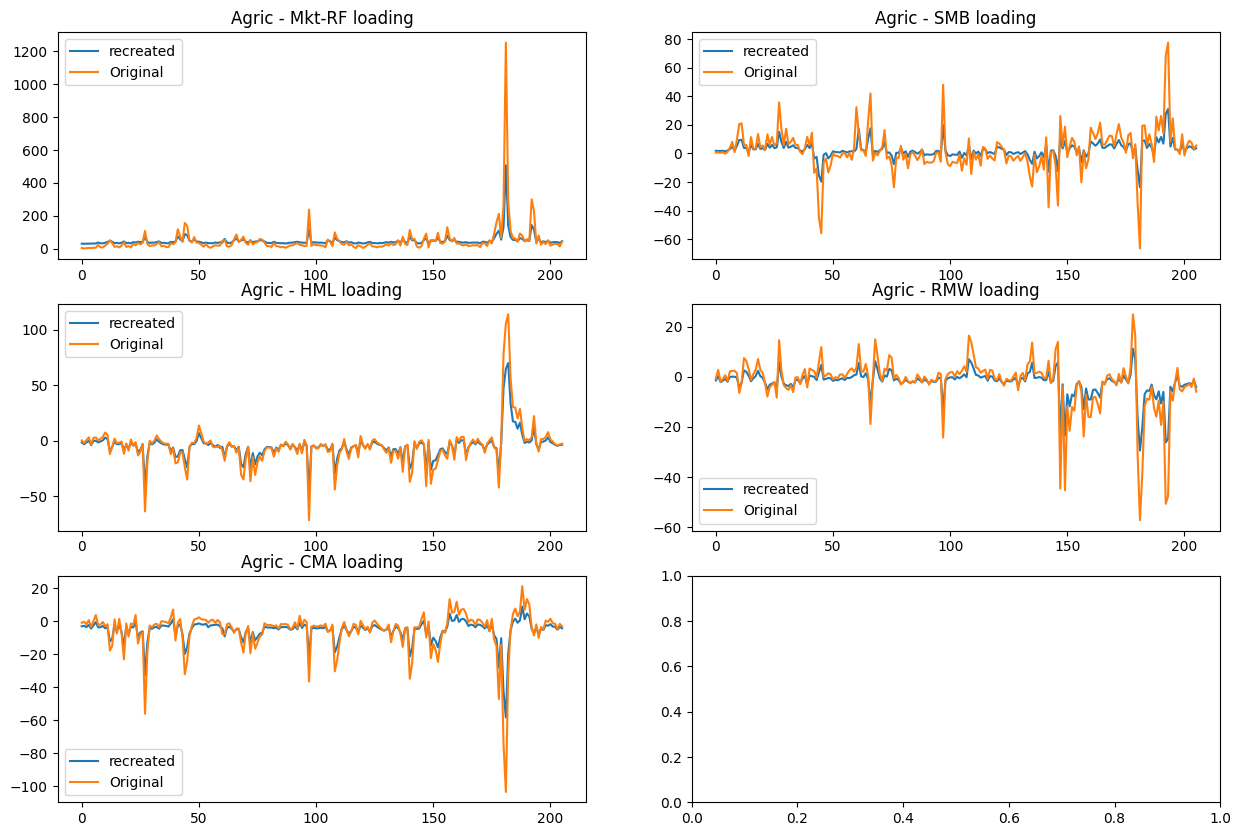

In [8]:
fig, axes = plt.subplots(3, 2, figsize = (15, 10))
axes = np.ravel(axes)
for i, factor in enumerate(factors):
    axes[i].plot(
        beta_loading.loc['Agric'].T[factor].values, label='recreated'
    )
    axes[i].plot(
        agric_betas[factor], label="Original"
    )
    axes[i].legend()
    axes[i].set_title(f"Agric - {factor} loading")


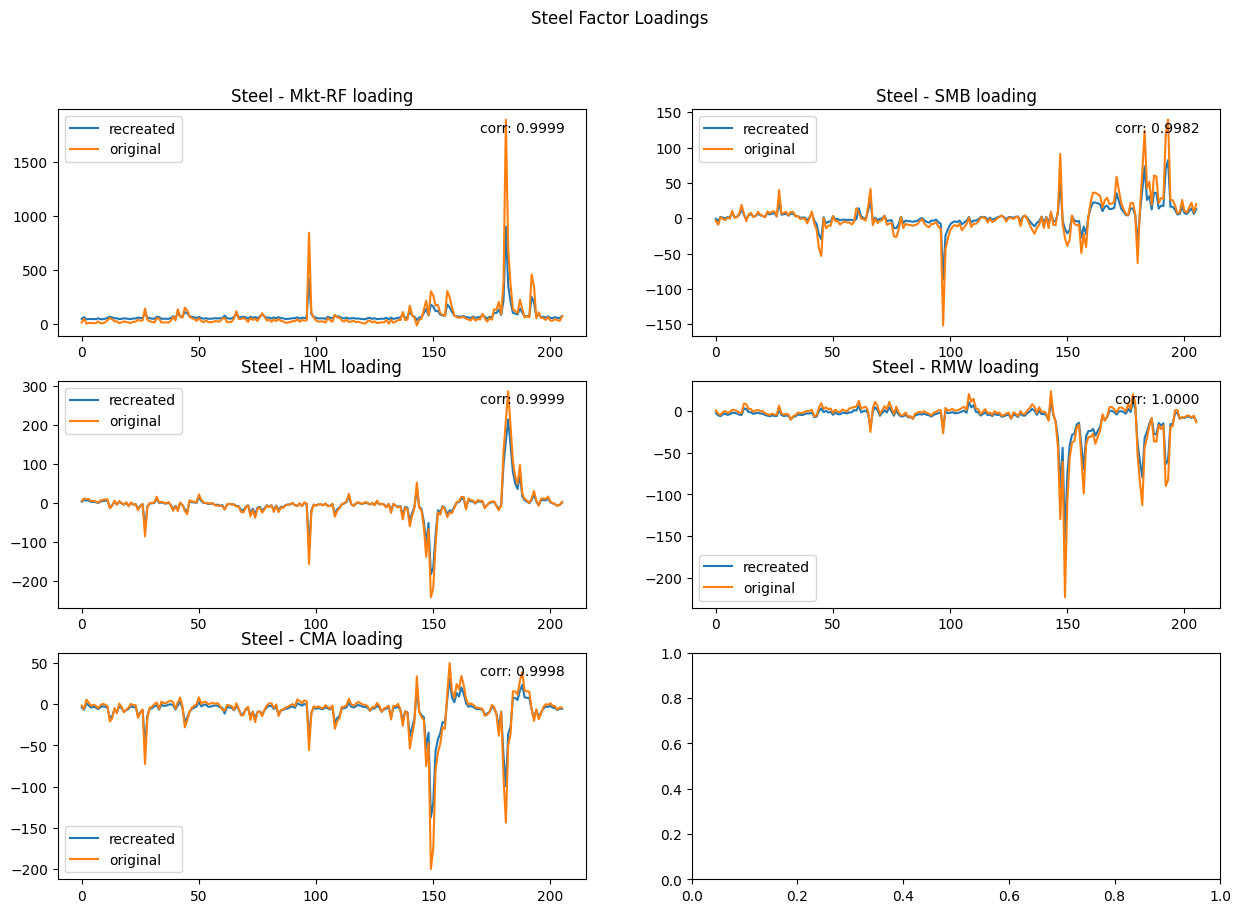

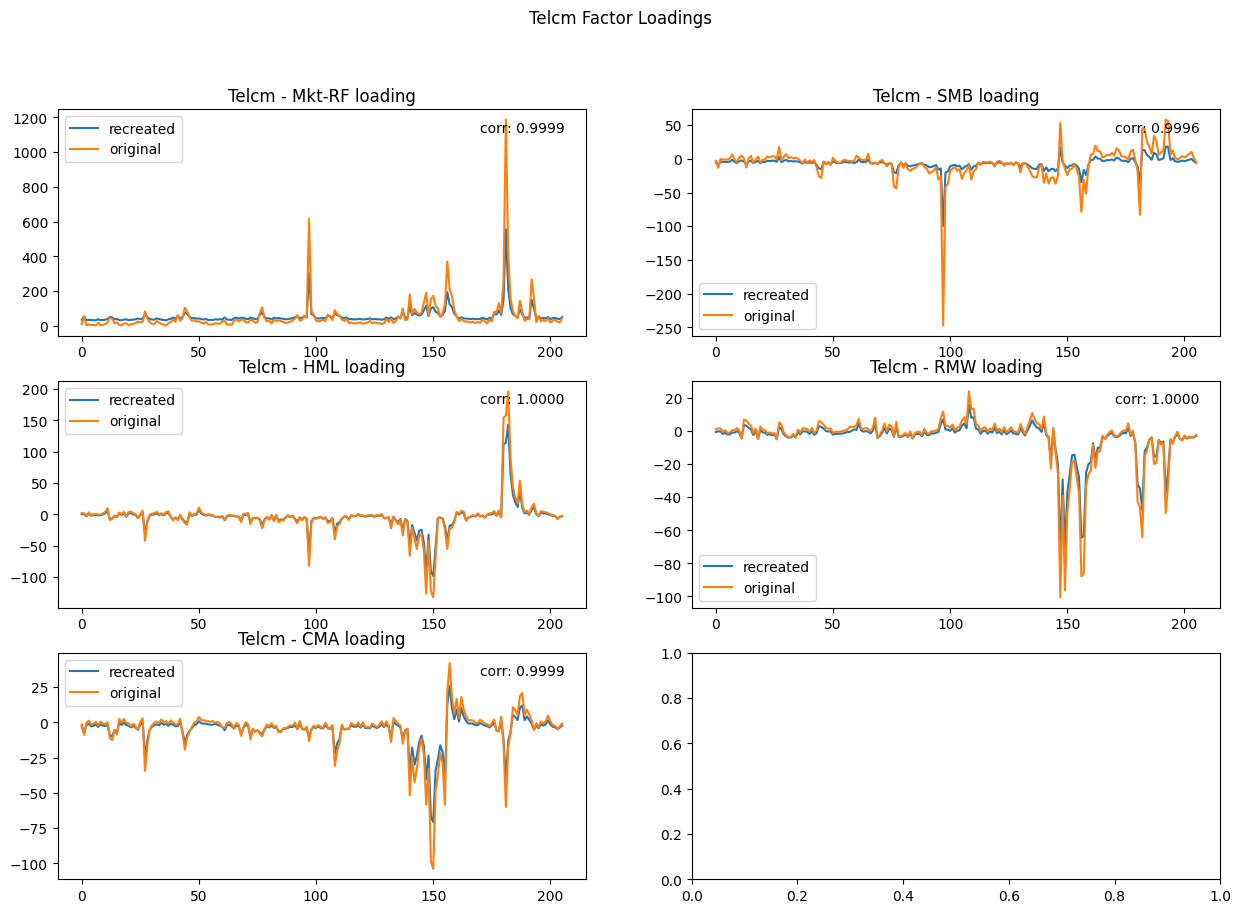

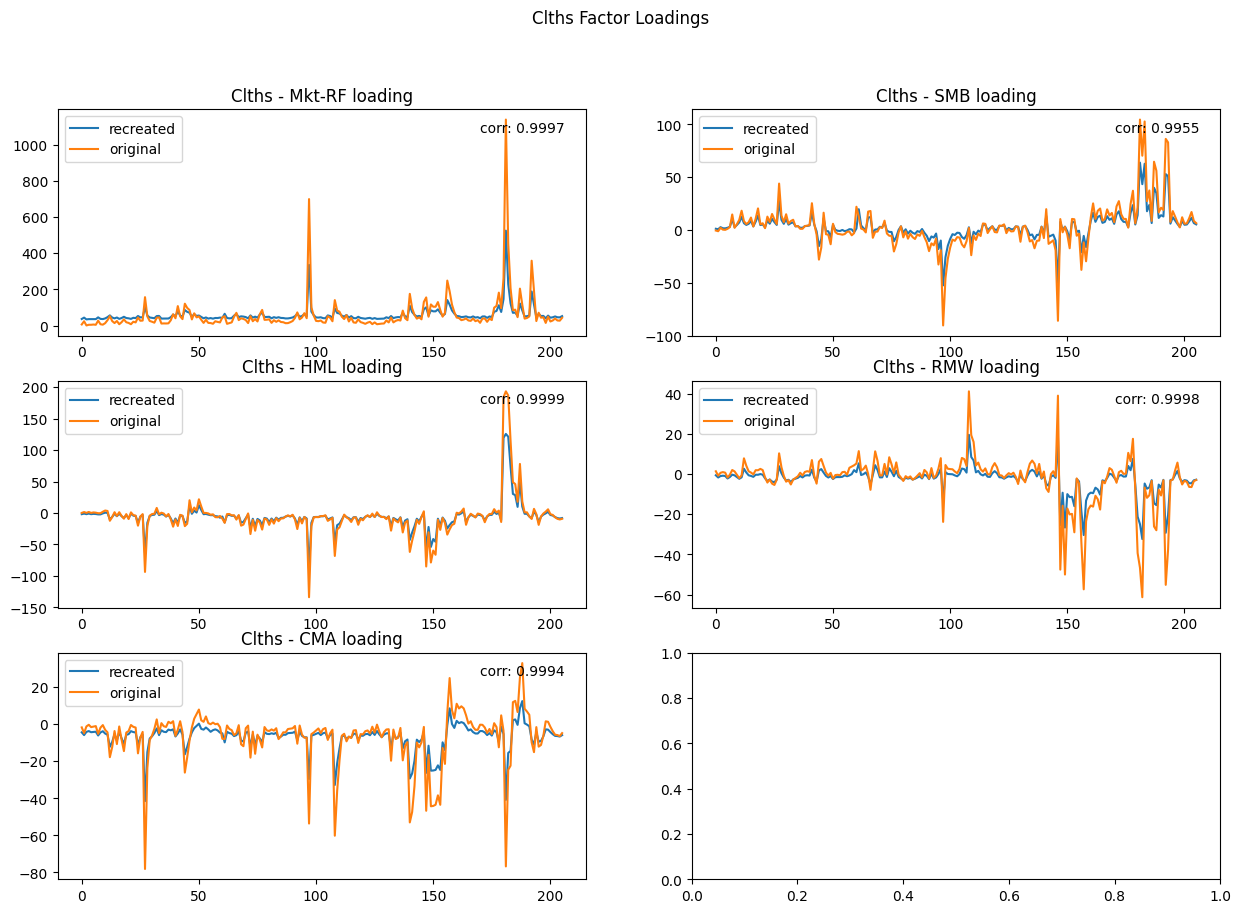

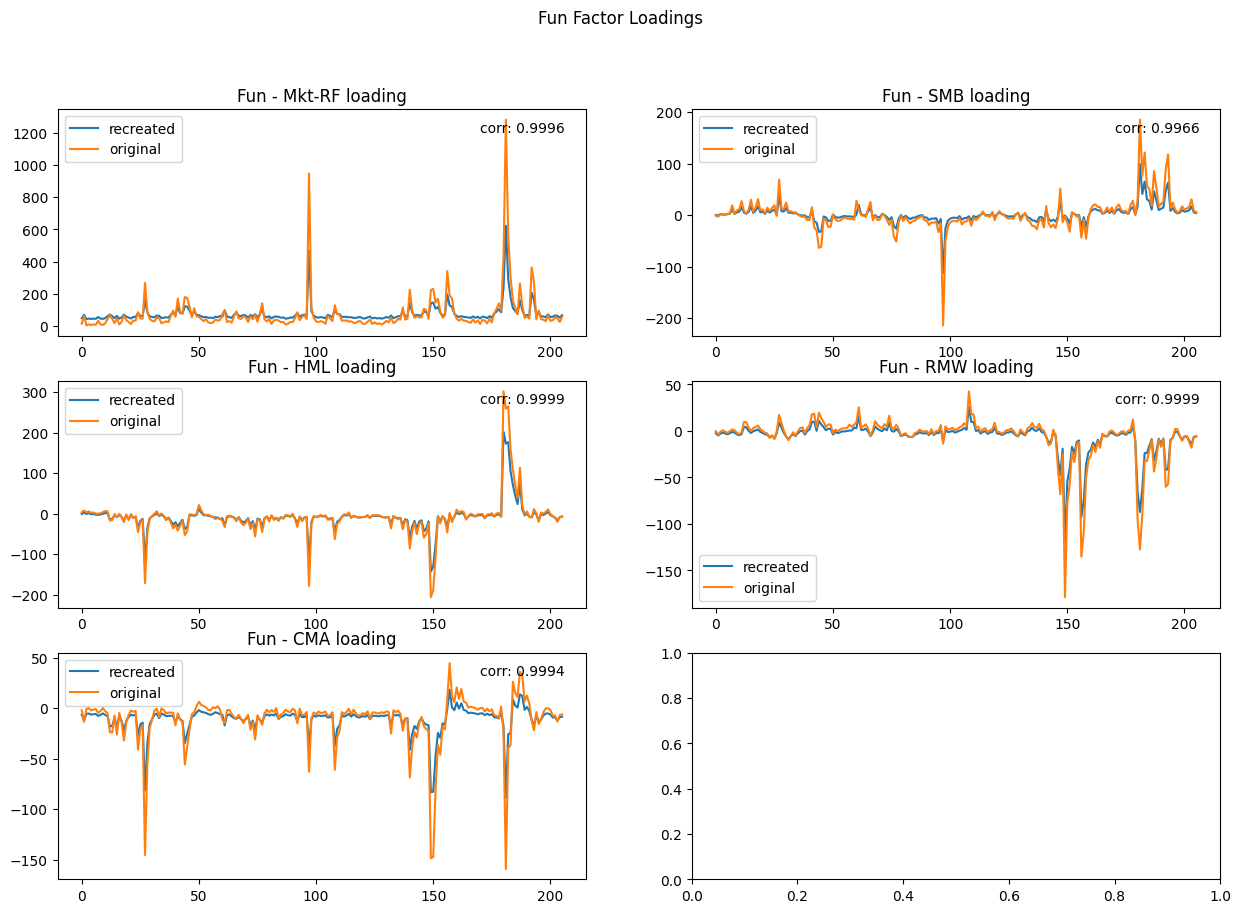

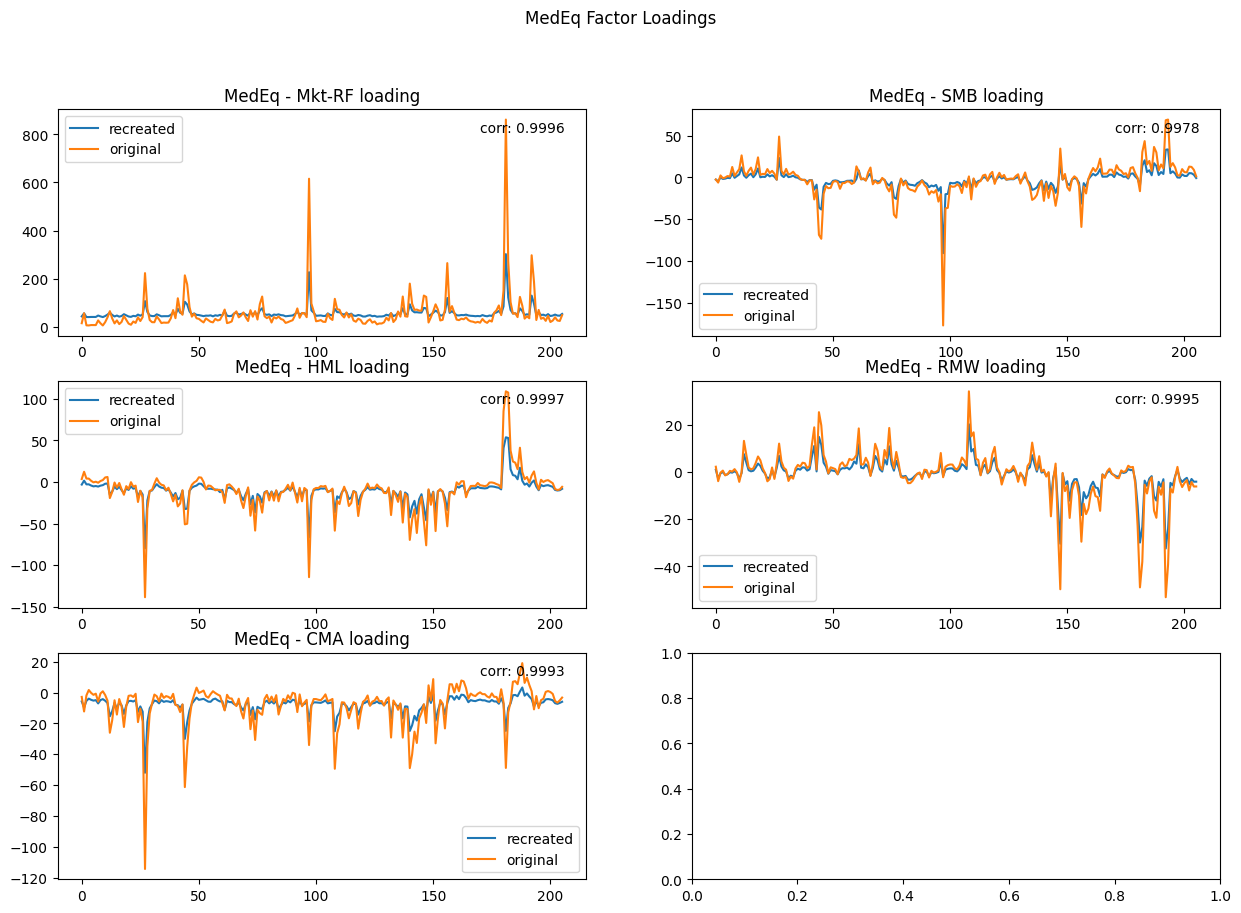

In [9]:
random_sample_assets = np.random.choice(47, 5, replace=False)

for rng in random_sample_assets:
    galvao_estimated_betas = pd.read_csv(f"../gmo-files/omegareg{rng + 1}.txt",
                    sep=r"\s+",
                    header=None)
    galvao_estimated_betas.columns = factors

    asset = assets[rng]

    fig, axes = plt.subplots(3, 2, figsize = (15, 10))
    axes = np.ravel(axes)
    for i, factor in enumerate(factors):
        recreated_arr = beta_loading.loc[asset].T[factor].values
        galvao_arr = galvao_estimated_betas[factor].values
        min_len = min(len(recreated_arr), len(galvao_arr))

        recreated_arr = recreated_arr[:min_len].astype(float)
        galvao_arr    = galvao_arr[:min_len].astype(float)

        axes[i].plot(recreated_arr, label='recreated')
        axes[i].plot(galvao_arr, label='original')

        recreated_arr = np.asarray(recreated_arr, dtype=float)
        galvao_arr    = np.asarray(galvao_arr, dtype=float)

        corr = np.corrcoef(recreated_arr, galvao_arr)[0, 1]
        axes[i].text(
            0.8, 0.9, 
            f"corr: {corr:.4f}",
            transform = axes[i].transAxes,
        )

        axes[i].legend()
        axes[i].set_title(f"{asset} - {factor} loading")
    fig.suptitle(f"{asset} Factor Loadings")
    plt.show()



As a final check, we sample all 47 industries and all 5 factors, and compute correlation for each of the 235 factor loadings. 

In [10]:
corr_df = pd.DataFrame(
    index = assets,
    columns = factors
)
for rng in range(47):
    galvao_estimated_betas = pd.read_csv(f"../gmo-files/omegareg{rng + 1}.txt",
                    sep=r"\s+",
                    header=None)
    galvao_estimated_betas.columns = factors
    asset = assets[rng]
    for i, factor in enumerate(factors):
        recreated_arr = beta_loading.loc[asset].T[factor].values
        galvao_arr = galvao_estimated_betas[factor].values
        min_len = min(len(recreated_arr), len(galvao_arr))
        recreated_arr = recreated_arr[:min_len].astype(float)
        galvao_arr    = galvao_arr[:min_len].astype(float)
        corr = np.corrcoef(recreated_arr, galvao_arr)[0, 1]
        corr_df.loc[asset, factor] = corr

corr_df

,Mkt-RF,SMB,HML,RMW,CMA
Agric,0.999567,0.983181,0.999695,0.99985,0.99928
Food,0.999763,0.997571,0.999783,0.999493,0.999491
Soda,0.999783,0.999295,0.999822,0.999621,0.999576
Beer,0.999574,0.994752,0.99978,0.999852,0.99884
Smoke,0.999736,0.999549,0.999402,0.999349,0.999224
Toys,0.999617,0.995785,0.999898,0.999834,0.999364
Fun,0.999625,0.996554,0.999913,0.999914,0.999411
Books,0.999854,0.997026,0.999914,0.999753,0.99961
Hshld,0.999651,0.999656,0.999402,0.99916,0.999419
Clths,0.999723,0.995539,0.999886,0.999774,0.999352


In [11]:
latex_table = corr_df.round(3).to_latex(
    index=True,
    header=True,
    float_format="%.3f",
    escape=False
)

print(latex_table)

\begin{tabular}{llllll}
\toprule
 & Mkt-RF & SMB & HML & RMW & CMA \\
\midrule
Agric & 1.000 & 0.983 & 1.000 & 1.000 & 0.999 \\
Food & 1.000 & 0.998 & 1.000 & 0.999 & 0.999 \\
Soda & 1.000 & 0.999 & 1.000 & 1.000 & 1.000 \\
Beer & 1.000 & 0.995 & 1.000 & 1.000 & 0.999 \\
Smoke & 1.000 & 1.000 & 0.999 & 0.999 & 0.999 \\
Toys & 1.000 & 0.996 & 1.000 & 1.000 & 0.999 \\
Fun & 1.000 & 0.997 & 1.000 & 1.000 & 0.999 \\
Books & 1.000 & 0.997 & 1.000 & 1.000 & 1.000 \\
Hshld & 1.000 & 1.000 & 0.999 & 0.999 & 0.999 \\
Clths & 1.000 & 0.996 & 1.000 & 1.000 & 0.999 \\
MedEq & 1.000 & 0.998 & 1.000 & 1.000 & 0.999 \\
Drugs & 1.000 & 1.000 & 1.000 & 0.999 & 0.999 \\
Chems & 1.000 & 0.999 & 1.000 & 1.000 & 0.999 \\
Rubbr & 1.000 & 0.992 & 1.000 & 1.000 & 0.999 \\
Txtls & 1.000 & 0.993 & 1.000 & 1.000 & 0.999 \\
BldMt & 1.000 & 0.995 & 1.000 & 1.000 & 0.999 \\
Cnstr & 1.000 & 0.994 & 1.000 & 1.000 & 1.000 \\
Steel & 1.000 & 0.998 & 1.000 & 1.000 & 1.000 \\
FabPr & 1.000 & 0.993 & 1.000 & 1.000 & 0.999